In [1]:
import jax
from jax import numpy as jnp

import tensorflow as tf

from vmoe.nn import models
from vmoe.data import input_pipeline
from vmoe.checkpoints import partitioned

from vmoe.configs.vmoe_paper.vmoe_s32_last2_ilsvrc2012_randaug_light1_ft_ilsvrc2012 import get_config, IMAGE_SIZE, BATCH_SIZE

import numpy as np
import matplotlib.pyplot as plt

import os
import uuid 
import tqdm
import logging

logging.basicConfig(filename='vmoe_datagen.log',level=logging.DEBUG, format='%(asctime)s %(message)s')

# change configuration in the above file.
os.environ['CUDA_VISIBLE_DEVICES'] = ''
_ = """
Adapted from vmoe/notebooks/demo_eee_CIFAR100.ipynb by Michael Li
Structure:
vmoe
    vmoe/
    this notebook
    vit_jax/ (from vision_transformer)
    vmoe_s32_last2_ilsvrc2012_randaug_light1_ft_ilsvrc2012.data-00000-of-00001
    vmoe_s32_last2_ilsvrc2012_randaug_light1_ft_ilsvrc2012.index
"""

2024-04-09 23:59:51.782958: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/zl310/anaconda3/envs/cs585_tf_google/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Construct model

In [2]:
model_config = get_config()
# print(model_config)
model_cls = getattr(models, model_config.model.name)
model = model_cls(deterministic=True, **model_config.model)
# print(type(model))
# print(model_config)

### Load weights

In [3]:
# using this model: 'gs://vmoe_checkpoints/vmoe_s32_last2_ilsvrc2012_randaug_light1_ft_ilsvrc2012'
checkpoint_prefix = 'vmoe_s32_last2_ilsvrc2012_randaug_light1_ft_ilsvrc2012'
checkpoint = partitioned.restore_checkpoint(prefix=checkpoint_prefix, tree=None)

print(checkpoint.keys())

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


dict_keys(['Encoder', 'cls', 'embedding', 'head'])


### Create dataset

In [4]:
dataset_config_test = model_config.dataset.test
dataset_test = input_pipeline.get_dataset(
    variant='test',
    name=dataset_config_test.name, 
    split=dataset_config_test.split, 
    batch_size=dataset_config_test.batch_size, 
    process=dataset_config_test.process
)

# dataset_config_test_real = model_config.dataset.test_real
# dataset_test_real = input_pipeline.get_dataset(
#     variant='test',
#     name=dataset_config_test_real.name, 
#     split=dataset_config_test_real.split, 
#     batch_size=dataset_config_test_real.batch_size, 
#     process=dataset_config_test_real.process
# )

def process_indices(indices_distr: dict[str: jnp.ndarray], batch_idx: int, mask,
                    class_lbl, fdir, batch_sz=BATCH_SIZE, img_sz: int = int(np.sqrt(144))):
    # img_sz * img_sz == number of tiles/patches in each 384*384 image. There are 144 tiles per image.
    class_lbl = np.array(class_lbl, dtype=np.uint16) * mask  # 2^16 = 65,536 > 1000
    img5 = np.zeros(shape=(batch_sz, int(img_sz * img_sz)), dtype=np.uint8)
    img7 = np.zeros(shape=(batch_sz, int(img_sz * img_sz)), dtype=np.uint8)

    exp, n, _ = indices_distr['idx_5'].shape
    for img, layer in zip([img5, img7], [indices_distr['idx_5'], indices_distr['idx_7']]):
        for expert in range(exp):
            for buf in range(n):
                if layer[expert, buf, 0] != 0 and layer[expert, buf, 1] != 0:
                    b_idx, p_idx = int(layer[expert, buf, 0]), int(layer[expert, buf, 1])
                    img[b_idx-1, p_idx-1] = expert  # img[batch_idx, patch_idx] = expert_id, 1-indexing
    img5_reshaped = img5.reshape(batch_sz, img_sz, img_sz)
    img7_reshaped = img7.reshape(batch_sz, img_sz, img_sz)
    if jnp.sum(mask) != batch_sz:
        img5_reshaped = img5_reshaped[mask]
        img7_reshaped = img7_reshaped[mask]
        logging.info(f"jnp.sum(mask) != batch_sz for batch_idx = {batch_idx}, jnp.sum(mask) = {jnp.sum(mask)}, batch_sz = {batch_sz}")
    ID = uuid.uuid4()
    np.save(os.path.join(fdir, f"x_{ID}_batch_{batch_idx}_layer_5.npy"), img5_reshaped)
    np.save(os.path.join(fdir, f"x_{ID}_batch_{batch_idx}_layer_7.npy"), img7_reshaped)

    np.save(os.path.join(fdir, f"y_{ID}_batch_{batch_idx}_layer_both.npy"), class_lbl)
    logging.info(f"finished for batch_idx = {batch_idx}")
    # indices_distr has shape (8, 55808, 512) for batch_size = 1024
    return


def gen_data(model, dataset, checkpoint, save_dir):
    ncorrect = 0
    ntotal = 0
    i = 0
    logging.info('-' * 10)
    logging.info('-' * 10)
    logging.info(f"start of generation file for save_dir = {save_dir}, BATCH_SIZE = {BATCH_SIZE}")
    for batch in tqdm.tqdm(dataset):
        # The final batch has been padded with fake examples so that the batch size is
        # the same as all other batches. The mask tells us which examples are fake.
        mask = batch['__valid__']
        # if jnp.sum(mask) != BATCH_SIZE:  # if there are some padded fake data inside of the current batch
        #     break
        # print(mask.shape)  # array of shape batch_size with boolean
        # plt.imshow(batch['image'][0])
        # print(jnp.argmax(batch['labels'], axis=1)[0])
        logits, _, indices_distr = model.apply({'params': checkpoint}, batch['image'])
    
        log_p = jax.nn.log_softmax(logits)
        preds = jnp.argmax(log_p, axis=1)
        true_lbl = jnp.argmax(batch['labels'], axis=1)
        # process_indices(indices_distr, class_lbl=true_lbl, fdir='/home/zl310/cs585_project/vmoe/expert_assign')
        process_indices(indices_distr, mask=mask, batch_idx=i, class_lbl=true_lbl, fdir=save_dir)

        ncorrect += jnp.sum((preds == true_lbl) * mask)
        ntotal += jnp.sum(mask)
        if i % 10 == 0:
          logging.info(f'Test accuracy, iteration {i}: {ncorrect / ntotal * 100:.2f}%')
        i += 1
    print(f'Test accuracy: {ncorrect / ntotal * 100:.2f}%')
    # return indices_distr

# ind_dist = gen_data(model, dataset_test, checkpoint)
gen_data(model, dataset_test, checkpoint, save_dir='/home/zl310/cs585_project/vmoe/expert_assign_test_ImageNetData')

2024-04-09 23:59:55.232971: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
0it [01:27, ?it/s]

[[5 6 6 6 6 6 5 5 5 5 5 5]
 [6 6 6 6 6 6 5 5 5 5 5 5]
 [6 6 6 6 5 5 5 7 7 7 5 5]
 [6 6 6 5 5 5 7 7 7 5 5 5]
 [5 7 7 7 7 7 7 7 7 5 6 5]
 [7 7 7 7 7 7 7 7 7 5 6 5]
 [7 7 7 7 7 7 7 7 7 5 5 5]
 [5 7 7 7 7 7 7 7 7 5 5 5]
 [6 5 6 7 5 7 4 7 7 3 5 5]
 [6 6 6 6 6 6 5 7 7 3 3 4]
 [6 6 6 6 6 6 6 5 6 5 4 5]
 [5 6 6 6 6 6 6 6 6 6 6 6]]
[[5 6 6 6 6 6 5 5 5 5 5 5]
 [6 6 6 6 6 6 5 5 5 5 5 5]
 [6 6 6 6 5 5 5 7 7 7 5 5]
 [6 6 6 5 5 5 7 7 7 5 5 5]
 [5 7 7 7 7 7 7 7 7 5 6 5]
 [7 7 7 7 7 7 7 7 7 5 6 5]
 [7 7 7 7 7 7 7 7 7 5 5 5]
 [5 7 7 7 7 7 7 7 7 5 5 5]
 [6 5 6 7 5 7 4 7 7 3 5 5]
 [6 6 6 6 6 6 5 7 7 3 3 4]
 [6 6 6 6 6 6 6 5 6 5 4 5]
 [5 6 6 6 6 6 6 6 6 6 6 6]]


(12, 12)


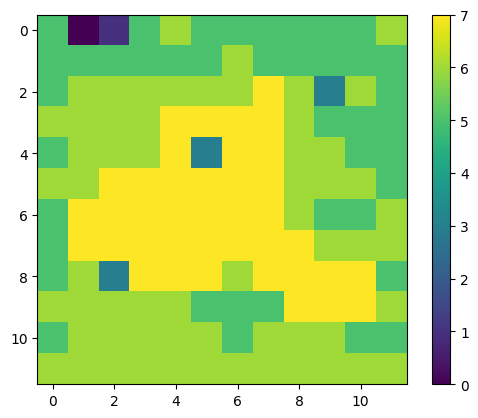

In [14]:
plt.imshow(i5[7])
print(i5[0].shape)
plt.colorbar()

In [6]:
# i, j, k = ind_dist['idx_5'].shape
# dd = {}
# for ii in range(i):
#     for jj in range(j):
#         if int(ind_dist['idx_5'][ii, jj, 0]) != 0:
#             mul = int(ind_dist['idx_5'][ii, jj, 0] - 1) * 145 + int(ind_dist['idx_5'][ii, jj, 1] - 1)
#             if mul not in dd.keys():
#                 dd[mul] = 1
#             else:
#                 dd[mul] += 1

# # for key in dd.keys():
# #     if dd[key] == 66:
# #         print(key)
# # print(max(dd.values()))
# plt.bar(np.array(list(dd.keys())), np.array(list(dd.values())))
# plt.xlabel("patch index")
# plt.ylabel("number of times the patch is assigned")

In [16]:
# # print(np.average(list(dd.values())))
# img = np.zeros(shape=(256, int(12 * 12)))
# for i in range(12*12):
#     img[0, i] = i+1
# new_img = img.reshape(256, 12, 12)
# print(img[0])
# print(new_img[0])
mask = np.array([True, True, True, False, False], dtype=np.bool_)
data = np.ones(shape=(5, 6, 6))
print(data[mask])

[[[1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1.]]

 [[1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1.]]

 [[1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1.]]]
